### **CC57 - MACHINE LEARNING - ENSAMBLE DE CLASIFICADORES**

Utilizaremos el conjunto de datos previamente utilizado en el laboratorio **07_ML_Naive_Bayes_Clasificador.ipynb** para la clasificaion de personas con /sin diabetes.  

Este conjunto de datos proviene del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales (USA).

El objetivo del conjunto de datos es predecir de forma diagnóstica si un paciente tiene diabetes o no, basándose en ciertas mediciones de diagnóstico incluidas en el conjunto de datos.

En particular, todos los pacientes aquí son **mujeres de al menos 21 años de edad** de **ascendencia india Pima**.

El dataset consta de 768 observaciones en 8 variables predictivas médicas y una variable objetivo: **Outcome** (resultado). Las variables predictoras incluyen el número de embarazos que ha tenido la paciente, su IMC, nivel de insulina, edad, etc.

####**(1) Carga de librerias**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
'''
rcParams (parámetros de configuración de tiempo de ejecución) proporciona una forma de extraer parte del código repetitivo en un archivo de configuración.
Esto da como resultado un código significativamente menos repetido y tramas consistentemente hermosas y bien diseñadas.'''
from matplotlib import rcParams

import seaborn as sns

#Visualizaciones
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Modelos y metricas
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



####**(2) Lectura y verificación dedatos**

In [3]:
data = pd.read_csv("diabetes.csv")

In [4]:
data.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Pregnancies,6.000000,1.000000,8.000000,1.000000,0.000000
Glucose,148.000000,85.000000,183.000000,89.000000,137.000000
BloodPressure,72.000000,66.000000,64.000000,66.000000,40.000000
SkinThickness,35.000000,29.000000,0.000000,23.000000,35.000000
Insulin,0.000000,0.000000,0.000000,94.000000,168.000000
BMI,33.600000,26.600000,23.300000,28.100000,43.100000
DiabetesPedigreeFunction,0.627000,0.351000,0.672000,0.167000,2.288000
Age,50.000000,31.000000,32.000000,21.000000,33.000000
Outcome,1.000000,0.000000,1.000000,0.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


####**(3) Comprobación de valores faltantes y tipo de datos**

<Axes: >

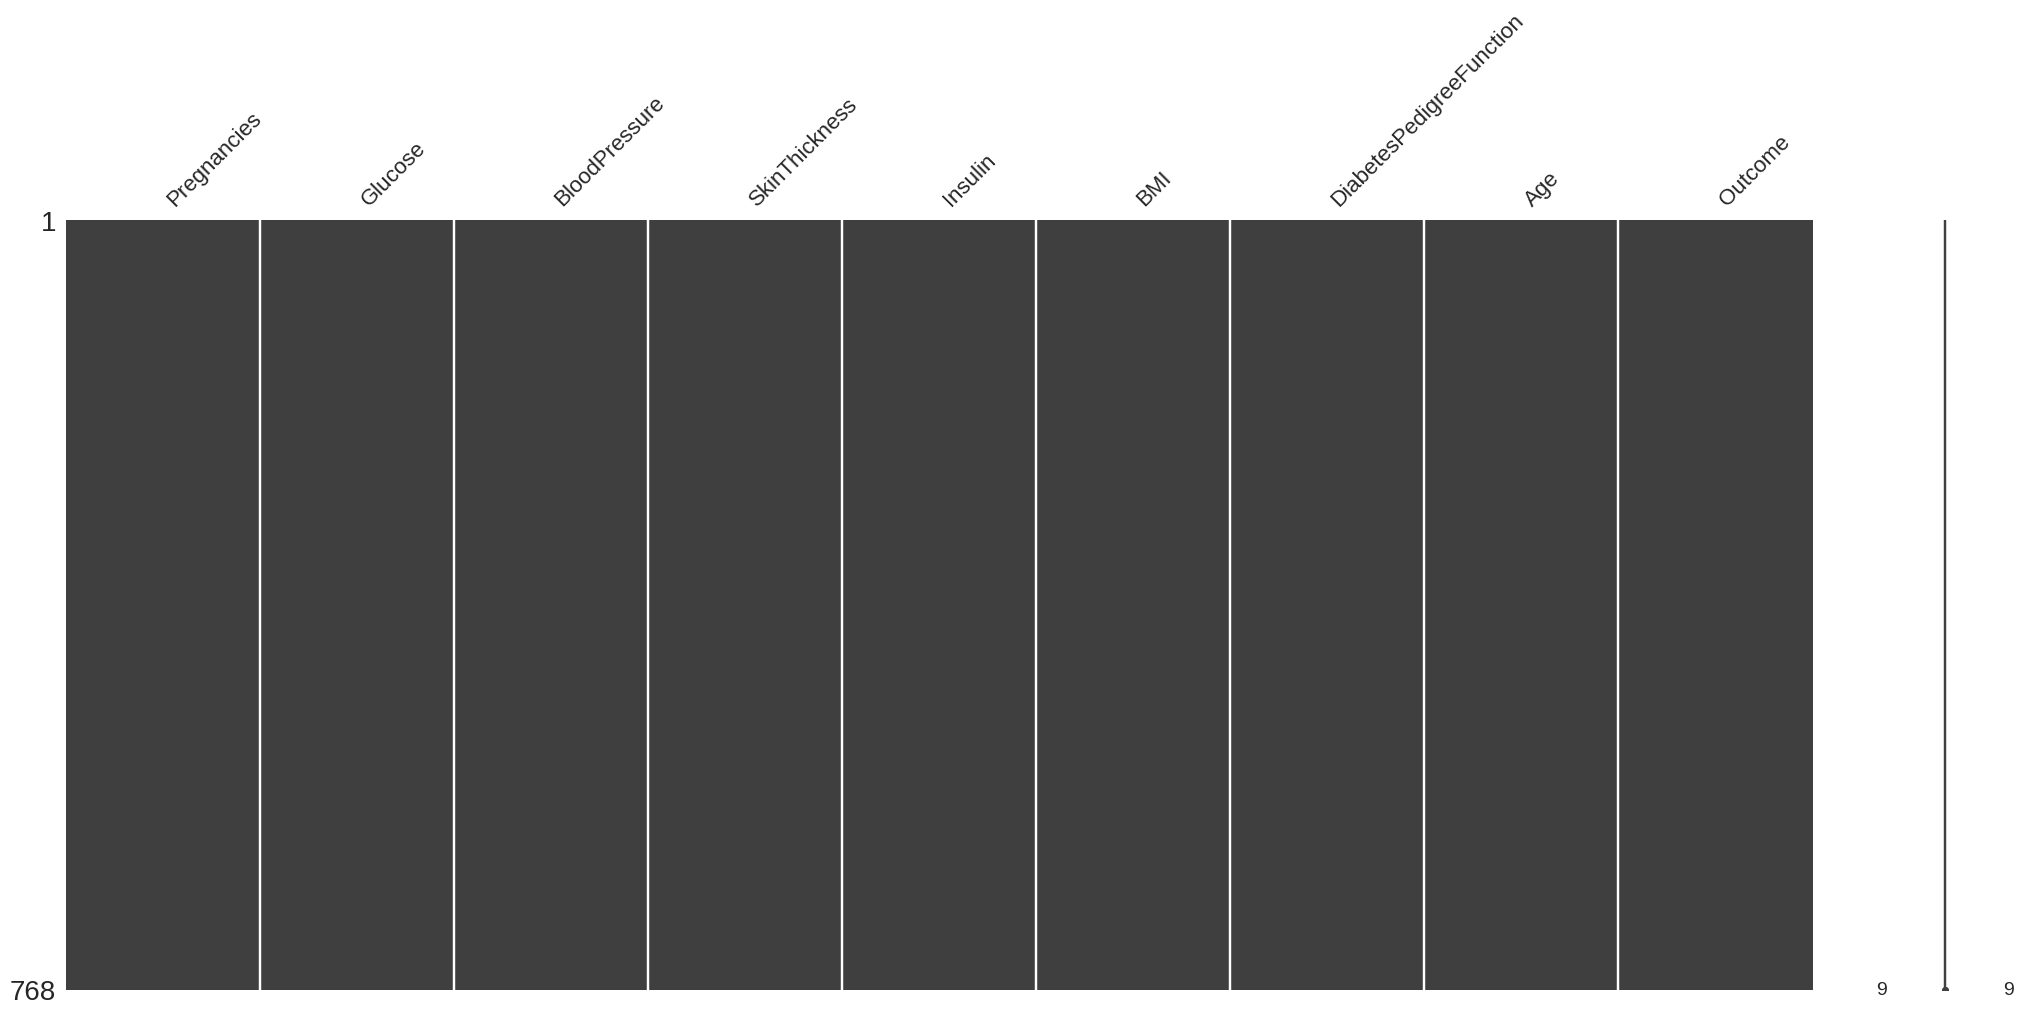

In [6]:
import missingno as msno
msno.matrix(data)

- No se observan datos faltantes

####**(4) Comprobación del desequilibrio o desbalance del atributo objetivo**

No hay un porcentaje específico que determine cuándo los datos de una clase objetivo se consideran desbalanceados de manera universal, ya que esto puede variar según el contexto del problema y la naturaleza de los datos. Sin embargo, hay algunas reglas generales que se pueden usar como guía:

-  **Proporción desigual**: Si la proporción entre las clases es significativamente desigual, por ejemplo, si una clase representa menos del 10% o incluso del 5% del total de muestras, es probable que se considere desbalanceada.

- **Ratio de 1:10 o mayor:** A menudo, se usa como regla general que si la relación entre la clase mayoritaria y la clase minoritaria es de al menos 10:1, entonces los datos se consideran desbalanceados.

- **Impacto en el rendimiento del modelo:** Independientemente de los porcentajes exactos, es importante observar cómo afecta el desbalance de clases al rendimiento del modelo. Si el desbalance de clases está causando que el modelo tenga un rendimiento deficiente en la detección de la clase minoritaria, entonces es necesario abordar este desbalance.

En muchos casos, es útil visualizar la distribución de las clases mediante gráficos como histogramas o diagramas de barras para tener una comprensión clara de la proporción de clases en el conjunto de datos.

En este caso, los datos de la clase objetivo no se encuentra desbalanceada.

In [7]:
data.shape

(768, 9)

In [8]:
data.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

- Se observa desbalance en los valores del atriuto objetivo Outcome

- Valor 1 significa que ha sido diagnosticado como positivo con diabetes

In [9]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = data['Outcome'].value_counts()/data['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

####**(5) Comprobación de estadísticas**

In [10]:
#Principales estadisticas
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Entre los atributos, se observa que hay muchas cuyo valor minimo es 0. Veamos que atributos son estos.

####**(6) Comprobación y eliminación de valores atípicos**

A partir de las siguientes visualizaciones, observamos que varios atributos tienen varios valores en cero y sería bueno cambiarlo a otro valor.

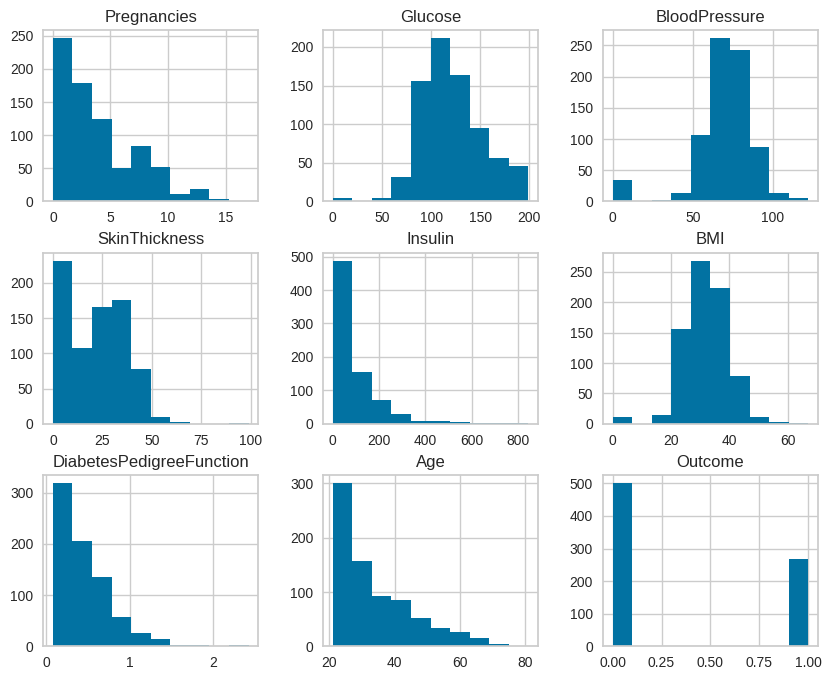

In [11]:
#visualizando los datos
#histograma

data.hist(figsize=(10,8))
plt.show()

In [12]:
#Primero, calculemos la proporción de valores cero en cada característica.

zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = data['Glucose'].count()

for feature in zero_features:
    zero_count = data[data[feature]==0][feature].count()
    print('{0} tiene {1} numero de casos en 0, significa un {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies tiene 111 numero de casos en 0, significa un 14.45 %
Glucose tiene 5 numero de casos en 0, significa un 0.65 %
BloodPressure tiene 35 numero de casos en 0, significa un 4.56 %
SkinThickness tiene 227 numero de casos en 0, significa un 29.56 %
Insulin tiene 374 numero de casos en 0, significa un 48.70 %
BMI tiene 11 numero de casos en 0, significa un 1.43 %


Como se muestra arriba, la relación entre el valor cero en los atributos SkinThickness e Insulin parece ser alta. Cambiemos los valores correspondientes al valor medio de cada característica.

In [13]:
diabetes_mean = data[zero_features].mean()
data[zero_features]=data[zero_features].replace(0, diabetes_mean)

Si eliminamos el valor cero de cada característica, tenemos una distribución similar a la distribución normal. Por lo tanto, podemos realizar un escalado lineal y un escalado estándar.

In [14]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

####**`(7) Scaling`**
Aunque los valores cero de cada característica se convierten en valores medios, algunas características tienen una forma unilateral. Por lo tanto, decidimos realizar un escalado no lineal y decidimos utilizar QuantileTransformer que cambia la distribución más cercana a la distribución normal.

In [15]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

In [16]:
#Separamos el conjunto de datos de entrenamiento y prueba a partir de los datos scalados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [17]:
#Luego del escalado de los datos de entrenamiento y habendo reemplazado los valores de cero con la media
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,4.315407,121.709154,72.144653,26.341978,118.600098,32.315027,0.468618,32.921875
std,2.916151,30.080570,12.113756,9.158041,94.570101,6.878494,0.339325,11.507539
min,1.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,100.000000,64.000000,20.536458,79.799479,27.275000,0.240000,24.000000
50%,3.845052,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,138.250000,80.000000,32.000000,127.500000,36.325000,0.612250,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Veamos si los atributos guardan un distribucion normal

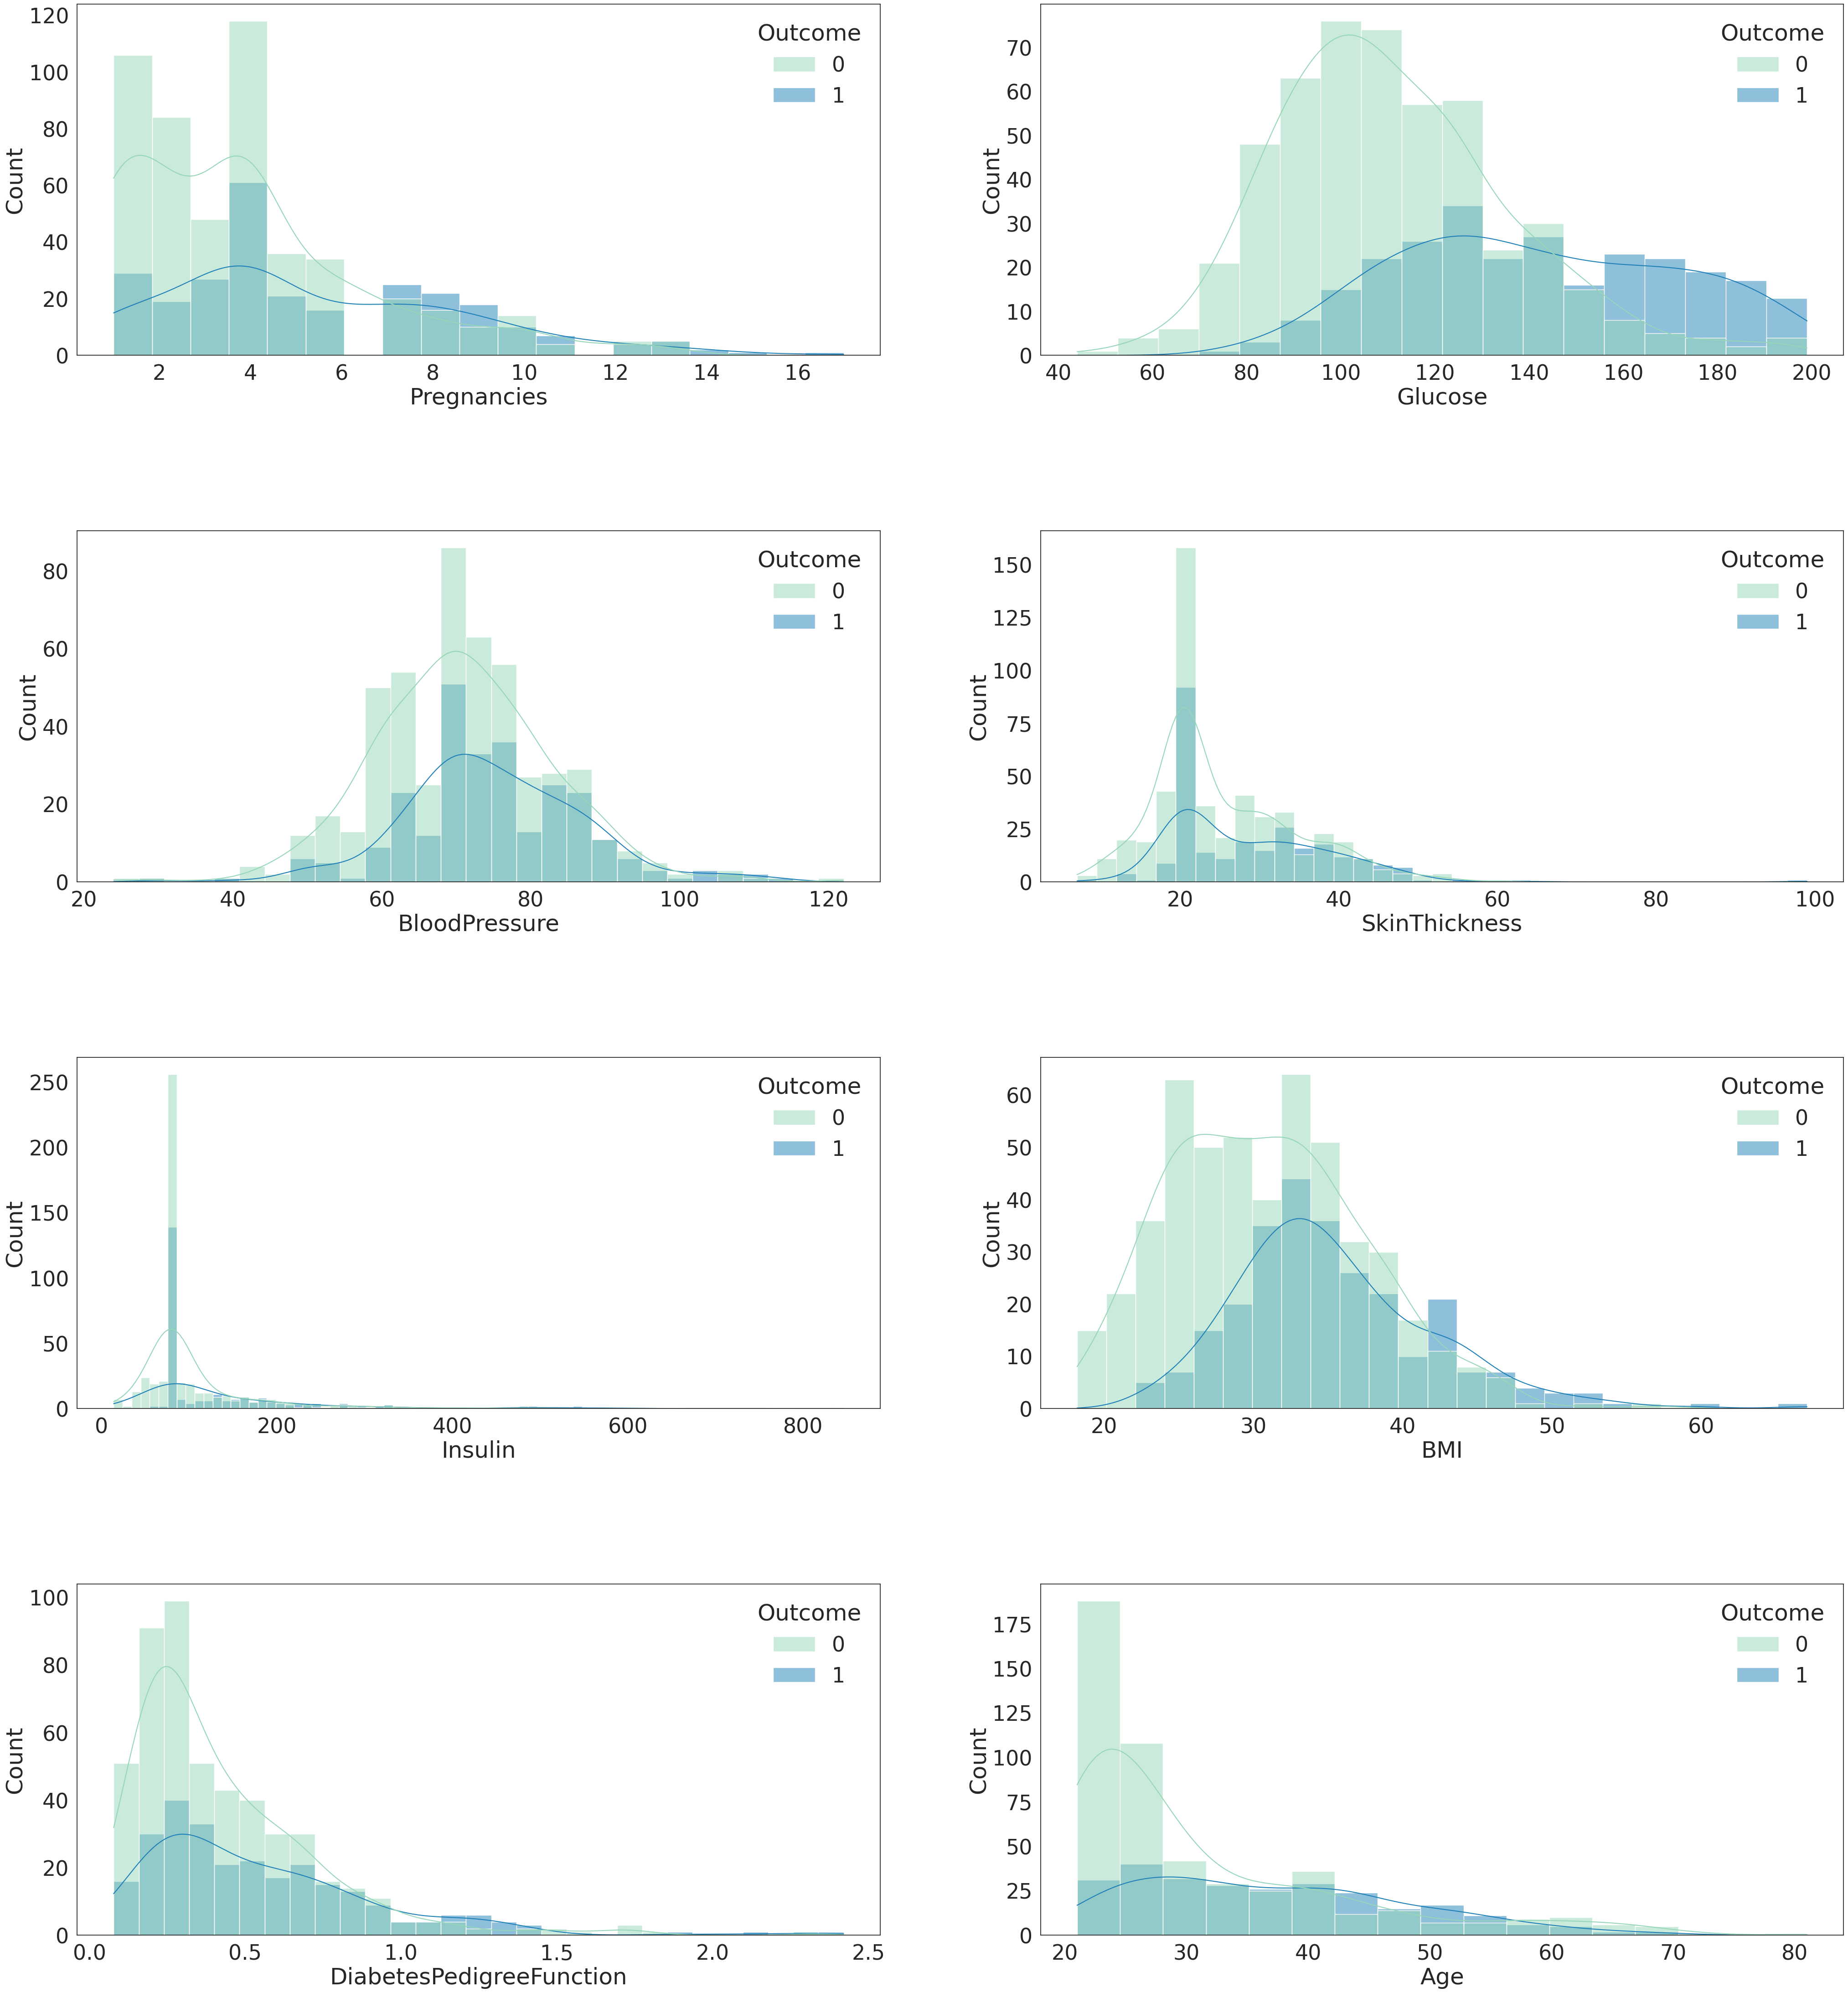

In [18]:
feature_names = [cname for cname in data.loc[:,:'Age'].columns]

rcParams['figure.figsize'] = 50,70
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=data, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Al observar las imagen de arriba, se puede ver que se elimina el valor cero y se realiza el escalado. Sin embargo, la distribución de los datos no parece buena.

####**(8) Comprobar la correlación entre características**

Text(0.5, 1.0, 'Gráfico de correlación')

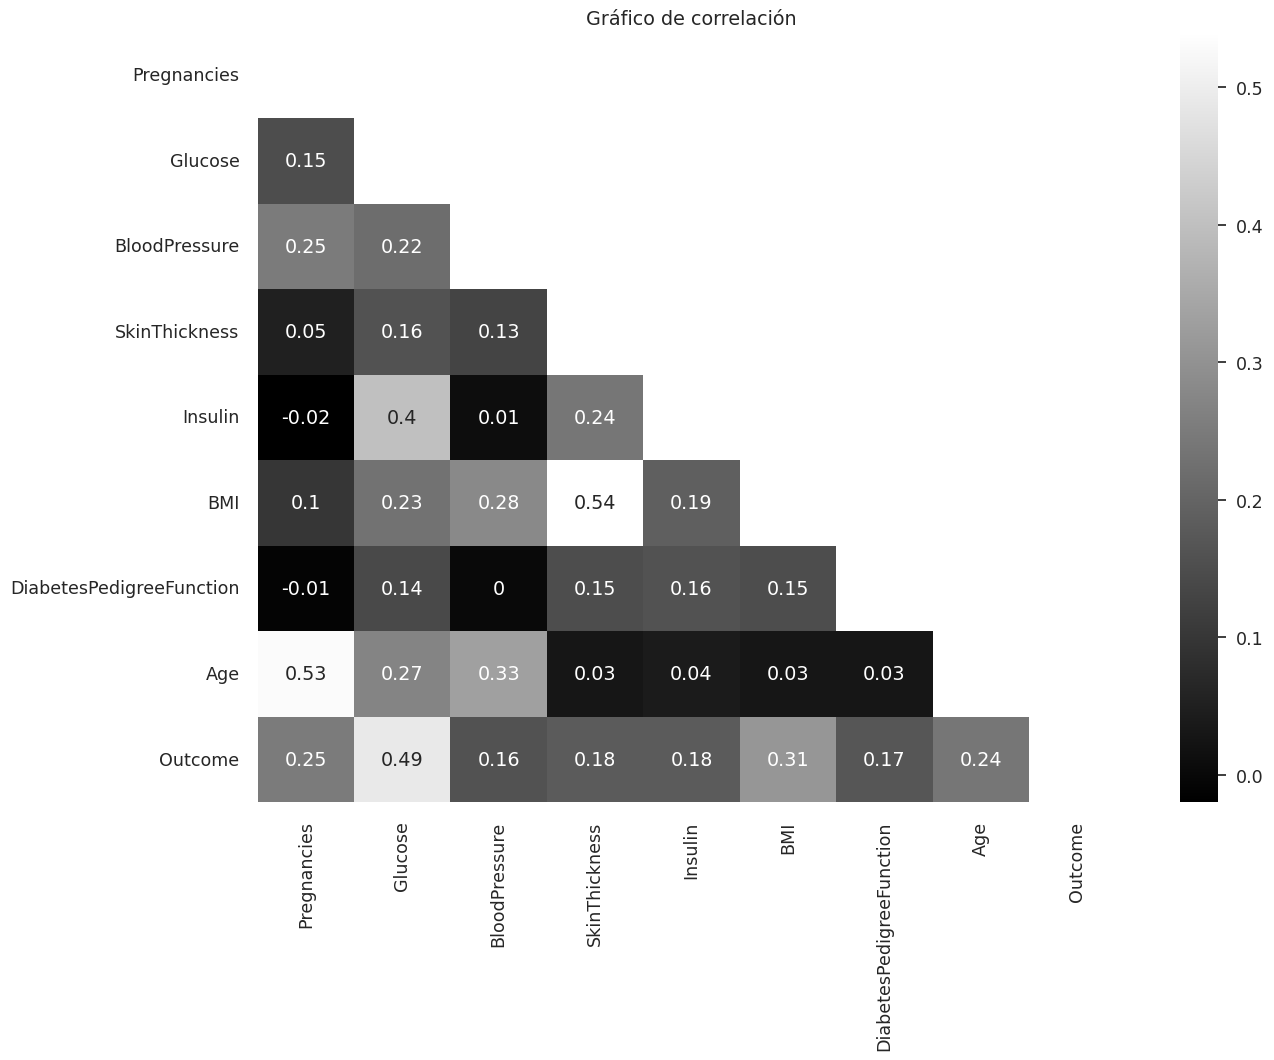

In [19]:
corr=data.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Gráfico de correlación')

<Figure size 1000x800 with 0 Axes>

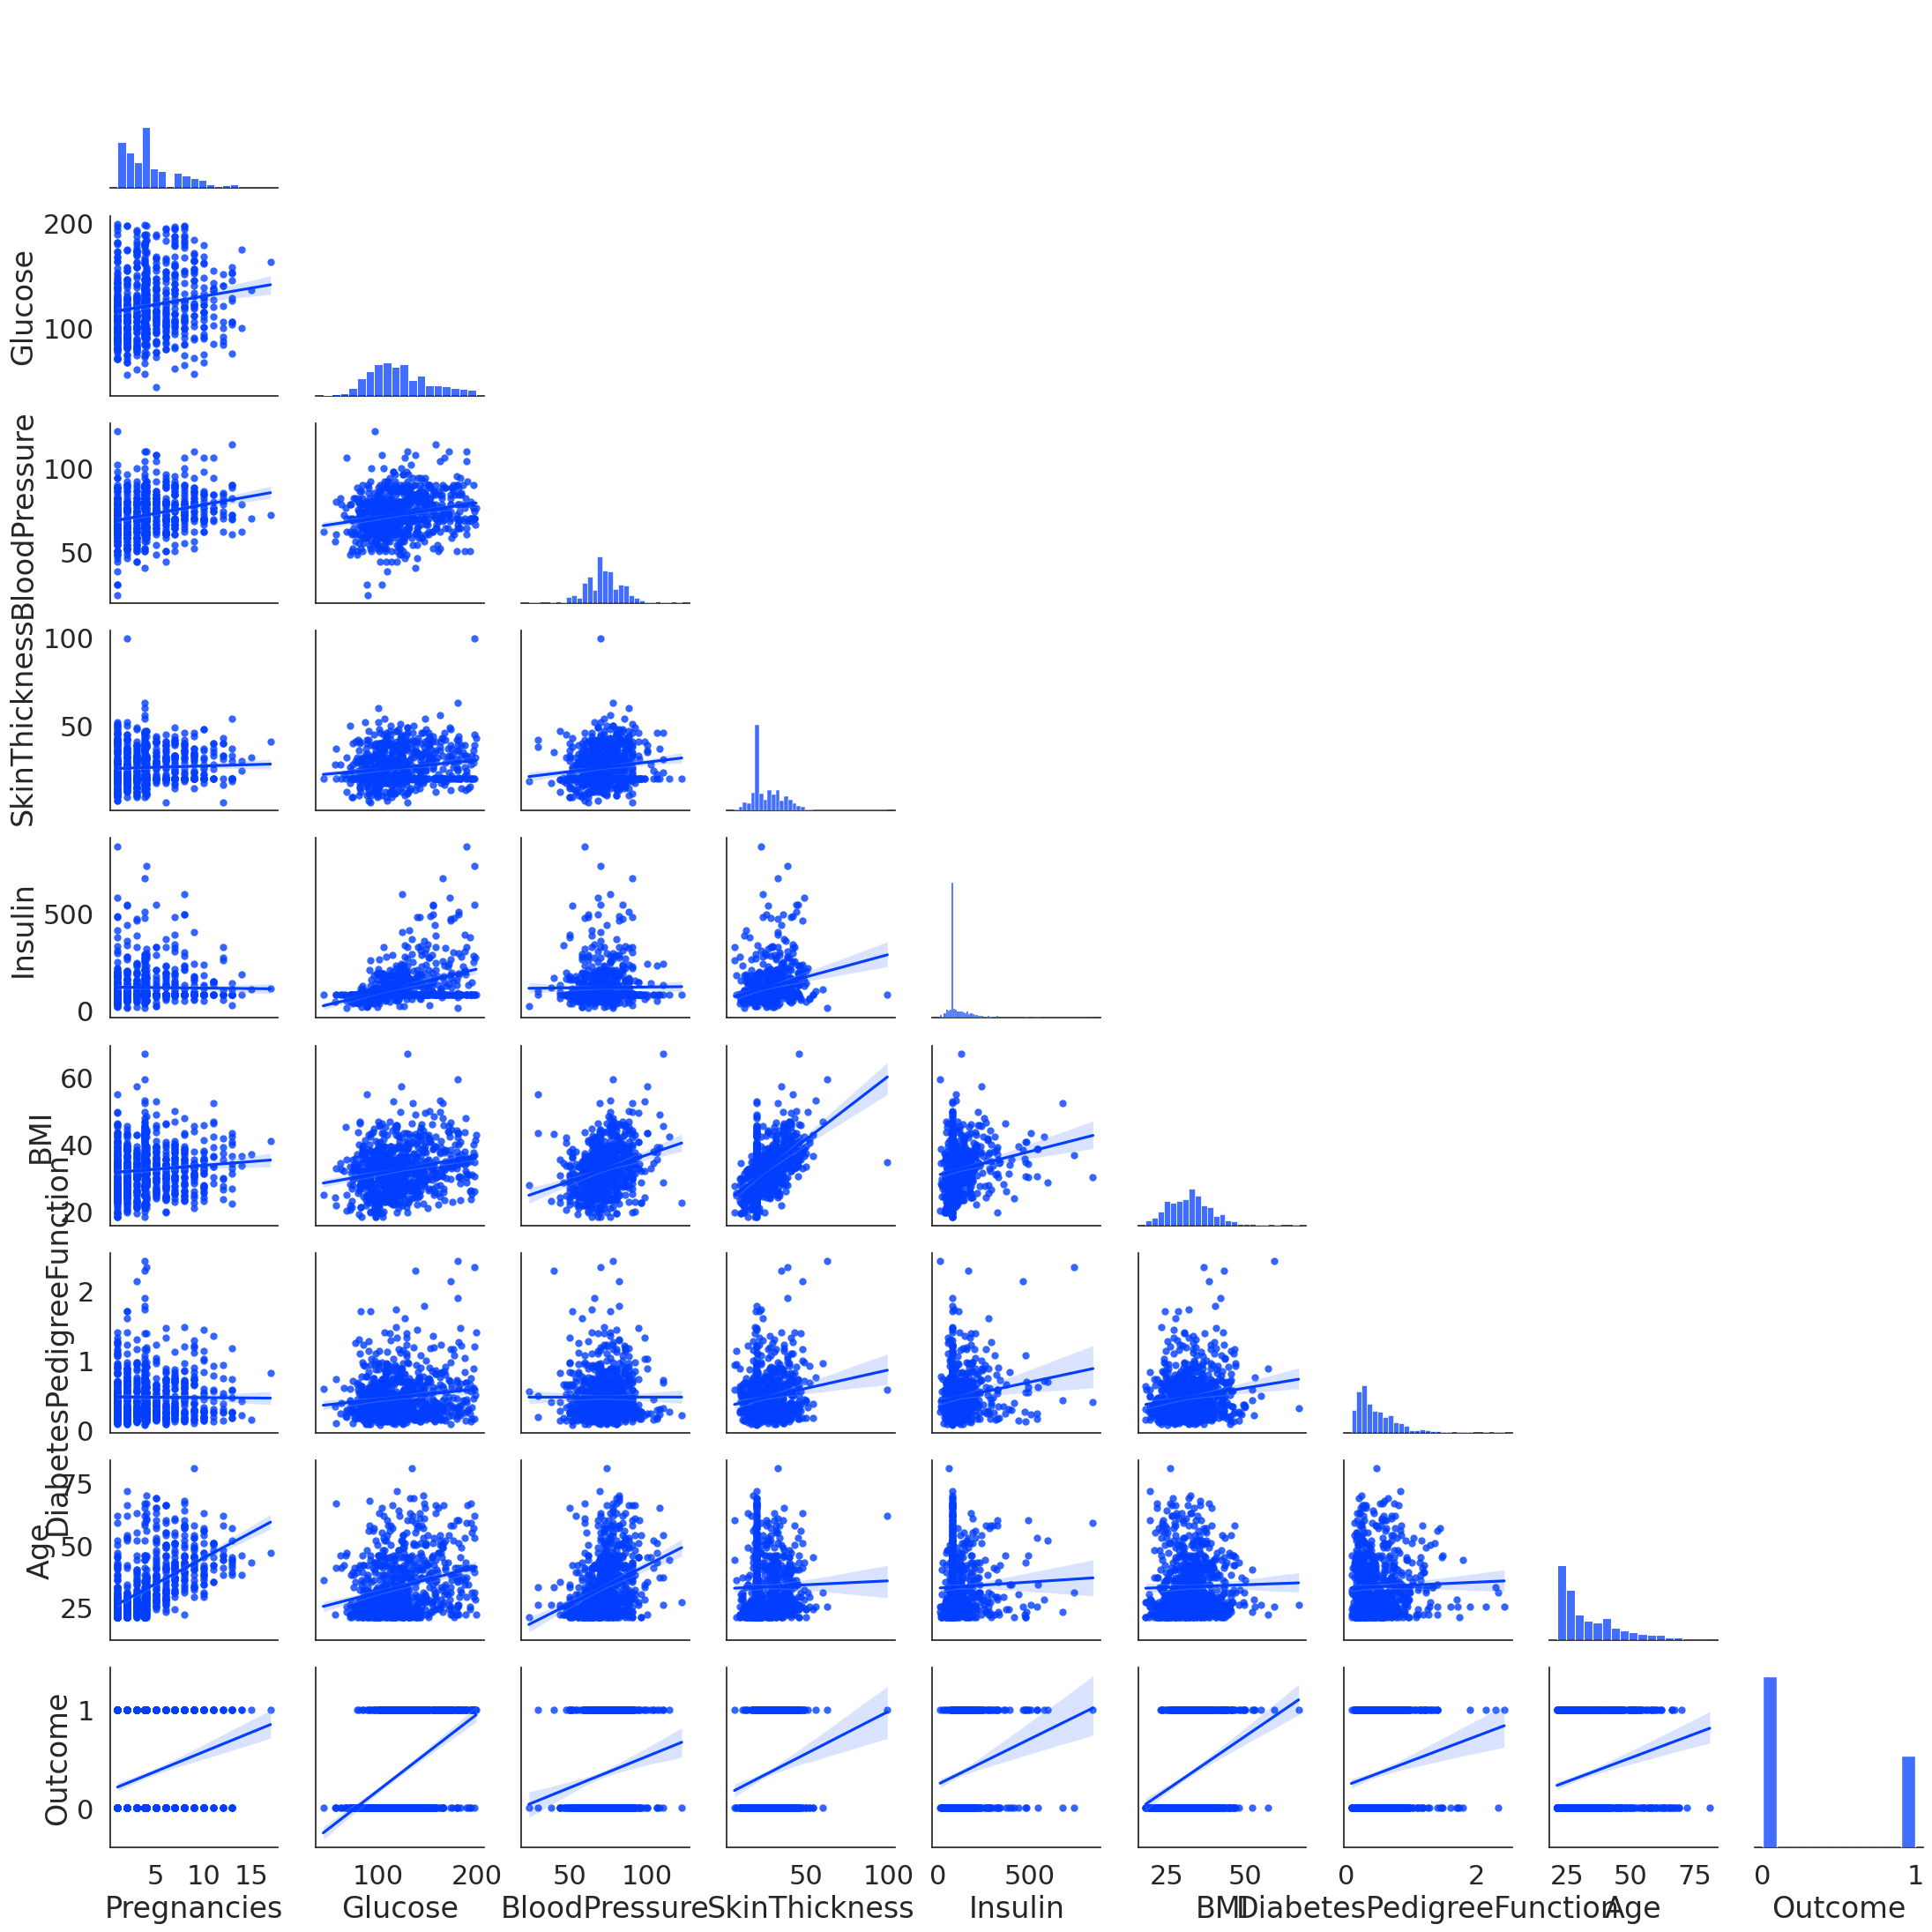

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(data,kind = 'reg',corner = True )

**Observación:**

- La correlación entre el resultado y la glucosa es alta. La glucosa parece ser la característica más importante en el entrenamiento de modelos.

- También se espera que el IMC, los embarazos y la edad se utilicen como características importantes en el entrenamiento de modelos.

- Alto coeficiente de correlación con SkinThickness e IMC. Puede haber un problema de multicolinealidad, pero si hay un problema de rendimiento después de verificar el resultado, verifíquelo nuevamente.

**OJO:**

La multicolinealidad es un problema común en el análisis de regresión cuando existe una alta correlación entre dos o más variables predictoras (también llamadas variables independientes o características). Esto significa que estas variables están altamente relacionadas entre sí y pueden proporcionar información redundante o duplicada sobre la relación con la variable dependiente (la variable que se está tratando de predecir).

####**(9) Comprobación de características antes de modelar**

Si observamos la figura anterior, el coeficiente de correlación entre el resultado y la glucosa es el más alto: 0,49. Examinemos esto con más profundidad.

In [21]:
fig = px.histogram(data, x="Glucose",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Histograma de glucosa por resultado",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [22]:
#Analizamos tambien las variables IMC y Edad
import plotly.express as px
fig = px.histogram(data, x="BMI",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Histograma del IMC por resultado (Outcome)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [23]:
fig = px.histogram(data, x="Age",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Histograma de edad por resultado (Outcome)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

En las figuras anteriores, podemos observar qué distribución tiene cada característica para cada salida (Outcome).

En el caso de la glucosa con alta correlación, se puede observar que la distribución de los resultados 1 y 0 tiene una forma más distante que otras características. En este caso, se espera que tenga un mejor efecto en la clasificación.

Ahora construyamos los modelos.

####**(10) Visualización del conjunto de datos de entrenamiento después de la reducción de dimensiones**

In [24]:
X_train = data.drop('Outcome',axis=1)
y_train = data['Outcome']

- **Visualizacion 2D**

Utilizaremos **UMAP** que es un algoritmo de reducción de dimensiones no lineal bastante flexible. Busca aprender la estructura múltiple de sus datos y encontrar una incrustación de baja dimensión que preserve la estructura topológica esencial de esa variedad.

Este algoritmo se encuentra en la libreria **umap-learn** la cual debemos instalar.

**UMAP (Uniform Manifold Approximation and Projection)** es una novedosa técnica de aprendizaje múltiple para la reducción de dimensiones.

In [25]:
!pip install umap-learn
!pip install umap-learn[plot] #Para las visualizaciones

<Axes: >

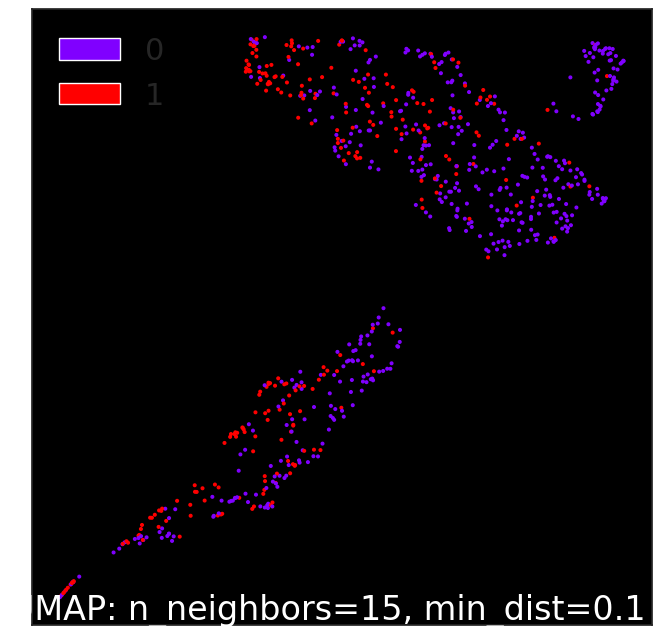

In [26]:
import umap
import umap.plot

mapper = umap.UMAP().fit(X_train)
umap.plot.points(mapper, labels=y_train, theme='fire')

El conjunto de datos de entrenamiento de 8 dimensiones que se muestra en la figura anterior se dibuja reduciendo las dimensiones a 2D. Como podemos ver en la figura, lo positivo y lo negativo se superponen en la parte inferior de la figura. Dado que nuestros modelos son principalmente modelos basados ​​en árboles, trabajaremos principalmente en determinar el límite, pero parece ser una tarea difícil en 2D.

Sin embargo, nuestro conjunto de datos de entrenamiento es de 8 dimensiones, solo que no podemos visualizarlo. Por lo tanto, no será una tarea muy difícil para nuestros modelos determinar el límite como se muestra arriba.

- **Visualizacion 3D**

In [27]:
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='label').astype(str)
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<class 'numpy.ndarray'>


Incluso si aumentamos la dimensión a 3D, podemos ver puntos superpuestos. Queremos verlo desde una dimensión superior, pero no podemos dibujar.

Ahora, todo lo que tenemos que hacer es hacer un buen modelado y ajustar los hiperparámetros.

####**(11) Ensamblado**

Utilizaremos dos librerias:
- La libreria **pycaret** para identificar que modelos seleccionar para ensamblar
- La libreria **sklearn ensemble** para crear los modelos ensamblados

####**11.1 Identificacion de Modelos a ensamblar**

Utilizaremos la **libreria pycaret**.   Esta ejecutara la función de inicializar el entorno de formación y crear el proceso de transformación. La función de configuración debe llamarse antes de ejecutar cualquier otra función. Se necesitan dos parámetros obligatorios: datos y objetivo. Todos los demás parámetros son opcionales.

In [28]:
#Instalamos la libreria pycaret
#!pip install pycaret
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to /tmp/pip-req-build-hko032vz
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /tmp/pip-req-build-hko032vz
  Resolved https://github.com/pycaret/pycaret.git to commit 885ebb81055ac017e50080db7731973d1a222e19
  Preparing metadata (setup.py) ... done


In [29]:
#Setup o configuracion utilizando pycaret.  El setup lo almacenamos en la variable clf1 o clasificador 1
#Se debe indicar el dataset y el atributo salida u objetivo
#Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

from pycaret.classification import *

clf1 = setup(data = data,
             target = 'Outcome',
             preprocess = False)

,Description,Value
0,Session id,4793
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8


La siguiente función entrena y evalúa el rendimiento de todos los estimadores disponibles en la biblioteca de modelos mediante **validación cruzada**. El resultado de esta función es una tabla de puntuación con puntuaciones promedio de validadas cruzadas.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html


In [30]:
#Determinamos aquellos modelos que no deseamos se incluyan
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7765,0.8313,0.5725,0.7278,0.6340,0.4788,0.4900,0.6190
lr,Logistic Regression,0.7653,0.8288,0.5512,0.7145,0.6142,0.4524,0.4645,1.7830
lda,Linear Discriminant Analysis,0.7653,0.8285,0.5512,0.7145,0.6142,0.4524,0.4645,0.0600
gbc,Gradient Boosting Classifier,0.7448,0.8274,0.5614,0.6618,0.6005,0.4168,0.4241,0.3670
et,Extra Trees Classifier,0.7615,0.8266,0.5503,0.7038,0.6143,0.4462,0.4554,0.4610
ada,Ada Boost Classifier,0.7469,0.8244,0.6099,0.6577,0.6249,0.4356,0.4425,0.3220
svm,SVM - Linear Kernel,0.5680,0.6778,0.4585,0.4653,0.3289,0.0863,0.1329,0.1170


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

####**11.2 VOTING: Clasificador por Votacion o Ensamble por Votacion**

**VotingClassifier** en Python es una clase proporcionada por la libreria Scikit-learn que permite combinar múltiples clasificadores en un clasificador único mediante votación. Esta técnica se conoce como ensamble de votación o votación mayoritaria.

Básicamente, **VotingClassifier** permite entrenar varios clasificadores independientes y luego combinar sus predicciones utilizando una **estrategia de votación** para tomar la decisión final sobre la clase de una muestra.

Hay dos tipos principales de votación admitidos por **VotingClassifier**:

- **Votación Dura (Hard Voting):** En este enfoque, cada clasificador en el ensamble emite un voto para predecir la clase de una muestra y la clase final predicha es determinada por mayoría de votos.

- **Votación Suave (Soft Voting):** En este enfoque, cada clasificador en el ensamble proporciona una distribución de probabilidad para cada clase en lugar de simplemente emitir una etiqueta de clase. La clase final predicha es determinada por la media ponderada de las probabilidades de clase de todos los clasificadores.

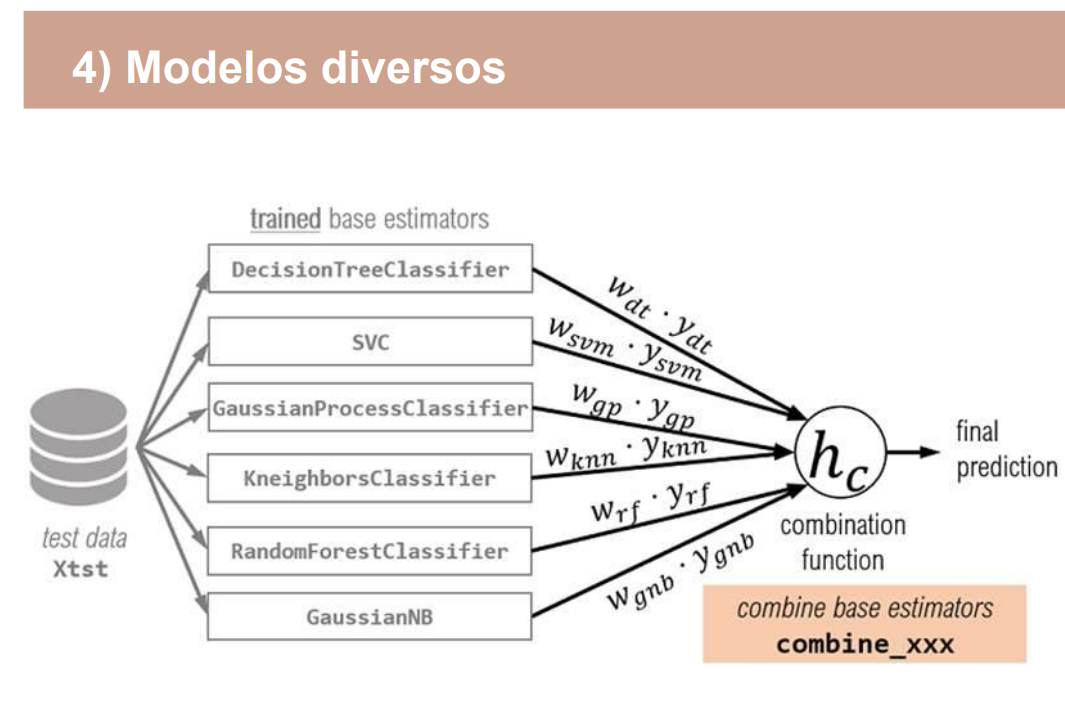

####- **Clasificador de votación dura**

Un clasificador ensamblado que combina las predicciones de otros  clasificadores en conjunto y genera la clase más frecuente, obtiene un tipo de clasificación (Clasificación de voto mayoritario) que se le conoce como **Clasificador de votación dura**.

Lo interesante aquí es que este tipo de clasificador de votación a menudo supera incluso al mejor clasificador del conjunto.

El siguiente código inicializa y entrena un clasificador que comprende tres clasificadores diferentes que serán SVM, Random Forest y Logistics Regression.

In [31]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

- **Inicializando los modelos**

In [32]:
log = LogisticRegression()
rnd = RandomForestClassifier(n_estimators=100)
svm = SVC()

Aquí estamos configurando **votación = "duro"** significa que se seguirá la regla de la mayoría y **n_estimators** como **100**. El resto de los parámetros son los predeterminados.

In [34]:
voting = VotingClassifier(
    estimators=[('logistics_regression', log),('random_forest', rnd), ('support_vector_machine', svm)],
    voting='hard')

- **Entrenando con el conjunto de datos de entrenamiento**

In [35]:
voting.fit(X_train, y_train)

VotingClassifier (estimators = [ ('logistics_regression', LogisticRegression()),
                                  ('random_forest',RandomForestClassifier()),
                                   ('support_vector_machine', SVC())])

VotingClassifier(estimators=[('logistics_regression',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('random_forest',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_a...
                                                     verbose=0,
                                                     warm_start=False)),
                             ('support_vector_machine',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False))],
                 flatten_transform=True, n_jobs=None, verbose=False,
                 voting='hard', weights=None)

- **Probando elclasificador**

In [36]:
#Ahora veamos cómo funciona esto en el conjunto de prueba:
for clf in (log, rnd, svm, voting):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.765625
RandomForestClassifier 1.0
SVC 0.7291666666666666
VotingClassifier 0.7864583333333334


Observamos que el clasificador de votación duraa supera solo a 2 de los 3 modelos individuales.

Si estamos trabajando con clasificadores que tienen el método predict_proba() significa que pueden estimar la probabilidad de una clase. Luego, generamos la clase con la mayor probabilidad que se promedia entre todos los clasificadores.
Esta técnica se conoce como votación blanda. Esta técnica suele funcionar mejor que la votación dura, ya que se centra más en los votos de mayor confianza.

Para usar la votacion blanda, solo hay que reemplazar "hard" por "soft" y tener en cuenta que esto solo funcionará para los clasificadores que pueden estimar la probabilidad de clase.

####**11.3 BAGGING**

Se entrenan predictores en un subconjunto aleatorio diferente de los datos de entrenamiento. Al final, cuando todos los predictores están entrenados, el conjunto puede predecir nuevos datos simplemente combinando la predicción de todos los predictores **de la misma manera que el clasificador de votación dura**. La mayoría de las veces, el conjunto tiene el mismo sesgo pero menos varianza que un predictor individual entrenado con los datos de entrenamiento originales.

La mayor ventaja deL BAGGING es que se puede entrenar en diferentes CPU o también en diferentes servidores y esta es una de las muchas otras razones por las que es un método muy popular.

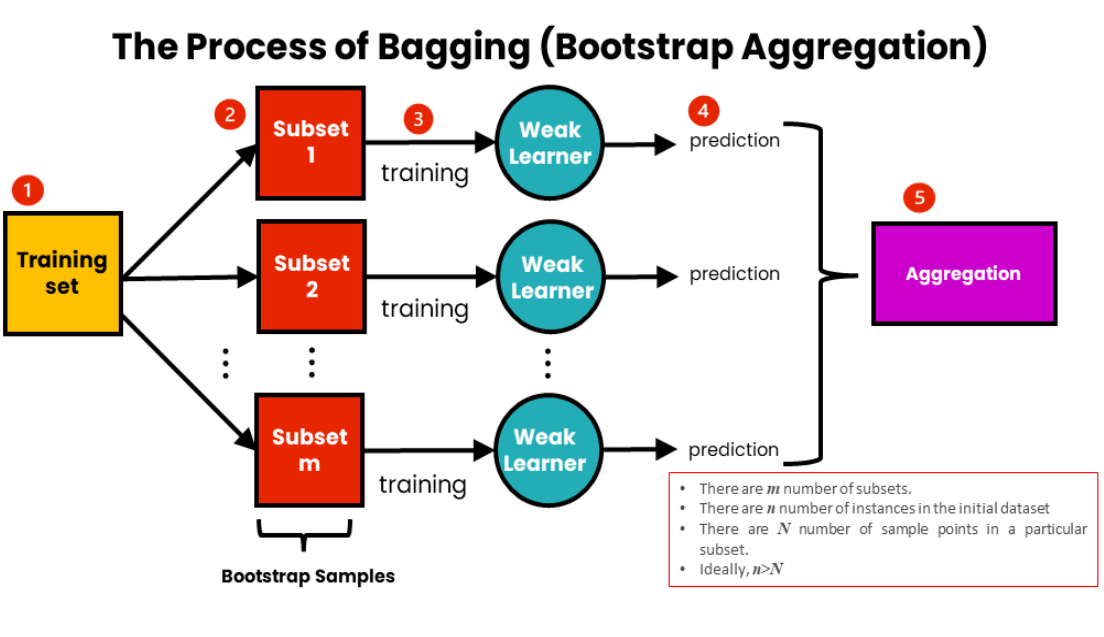

- **Importamos las librerias necesarias**

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

- **Inicializamos el clasificador Bagging**

El siguiente código entrenará un conjunto de 250 clasificadores de árboles de decisión (n_estimadores), y cada uno de ellos se entrena con 100 subconjuntos aleatorios de los datos de entrenamiento (max_samples) con reemplazo mientras estamos trabajando.

Por último, los parámetros n_jobs especifican cuántos núcleos de CPU desea usar para entrenamiento y predicción (-1 significa que puede usar todos los disponibles). Para problemas de regresión, se puede utilizar BaggingRegressors.

In [39]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=250,
    max_samples=100, bootstrap=True, random_state=101)

- **Entrenando con el conjunto de datos de entrenamiento**

In [40]:
bagging_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=True, bootstrap_features=False,
                  estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   monotonic_cst=None,
                                                   random_state=None,
                                                   splitter='best'),
                  max_features=1.0, max_samples=100, n_estimators=250,
                  n_jobs=None, oob_score=False, random_state=101, verbose=0,
                  warm_start=False)

- **Probando el clasificador**

In [41]:
y_pred = bagging_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.796875


- **Evaluacion inmediata**

Siempre que se utiliza el bagging, hay una cierta cantidad de datos que se pueden muestrear (seleccionando un subconjunto) más de una vez, o quizás incluso más, y es posible que haya algunos datos que no se muestreen en absoluto. El clasificador Bagging toma muestras de n instancias de entrenamiento con reemplazo de forma predeterminada, lo que significa que solo se muestrea alrededor del 63% de los datos en promedio para cada predictor. El resto del 37% de los datos no se muestrean en absoluto; ahora estos datos/instancias se conocen como **instancias listas para usar (OOB)**. Recordemos que este 37% no es igual para todos los predictores.

Dado que nuestro modelo nunca antes había visto estos datos, puede ser útil para evaluar y eliminar la necesidad de datos de validación separados.
Bagging tiene un parámetro **oob_score** que, al establecerse como verdadero, utilizará automáticamente **oobs** para la evaluación una vez finalizado el entrenamiento.

- **Clasificador Bagging con validacion inmediata** (oob_score=True)

In [42]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=250,
    bootstrap=True, oob_score=True, random_state=101)

In [43]:
bagging_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=True, bootstrap_features=False,
                  estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   monotonic_cst=None,
                                                   random_state=None,
                                                   splitter='best'),
                  max_features=1.0, max_samples=1.0, n_estimators=250,
                  n_jobs=None, oob_score=True, random_state=101, verbose=0,
                  warm_start=False)

In [44]:
bagging_clf.oob_score_

0.76171875

Obtenemos el 76%, que está bastante cerca de lo que logramos antes (79,6%). Entonces, al probar el modelo en OOB podemos obtener una estimación aproximada de la precisión que lograremos en el conjunto de prueba.

####**11.4 BOOSTING**

Básicamente lo que hace este clasificador es entrenar a los predictores en orden secuencial, cada uno de ellos corrige el error de su predecesor. Hay muchos algoritmos de impulso que Scikit-learn ofrece, pero los mejores y más populares son AdaBoost (Adaptive Boosting) y Gradient Boosting.

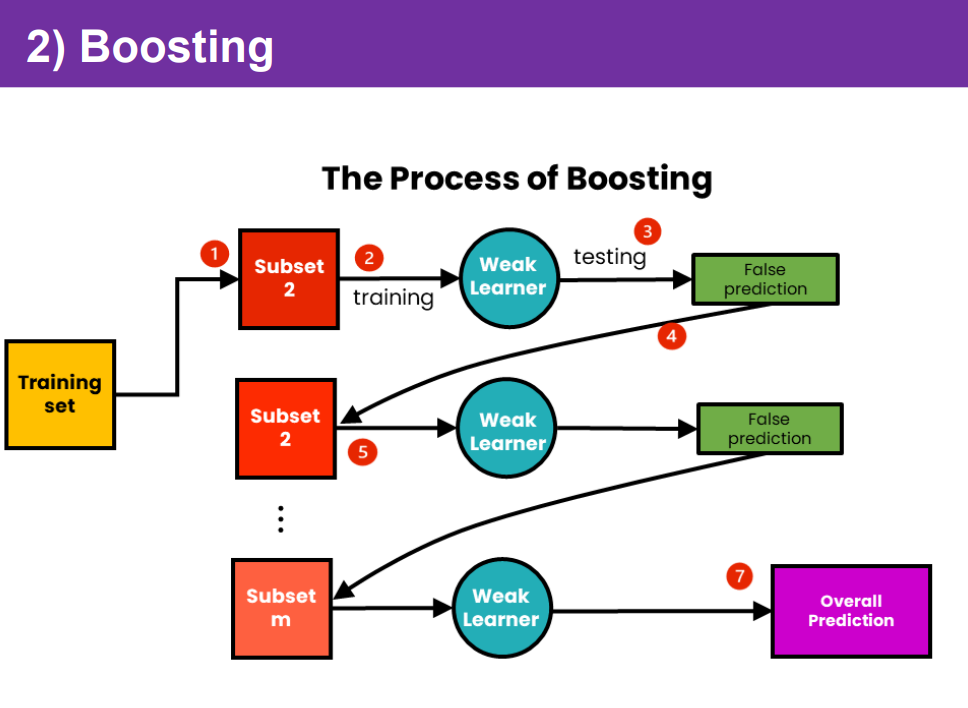

- **AdaBoost**

Al entrenar un **clasificador Adaboost**, el algoritmo primero entrena un clasificador base (supongamos árboles de decisión) y después del entrenamiento utiliza este clasificador base para hacer predicciones sobre los datos de entrenamiento. Después de esto, el algoritmo aumenta su peso relativo para las instancias de entrenamiento en las que nuestro clasificador base se equivocó (clasificación errónea). Luego entrena a otro clasificador con estos pesos nuevos (actualizados) y nuevamente hace predicciones sobre los datos de entrenamiento y actualiza sus pesos en consecuencia, y este proceso continúa.

Una vez que todos los predictores están entrenados y listos para funcionar, el conjunto hace predicciones similares al Bagging, la única diferencia es que los predictores tienen pesos diferentes según la precisión (clasificaciones correctas) de los datos de entrenamiento.

Uno de los principales inconvenientes  de este enfoque secuencial es que no se pueden paralelizar, lo que significa que no se pueden entrenar en diferentes sistemas al mismo tiempo, ya que cada uno de los predictores requiere el entrenamiento y la evaluación de sus predictores anteriores. Por lo tanto, no escalan como si se tratase de Bagging.

- **Inicializamos y entrenamos el clasificador AdaBoost**

In [45]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=1,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    monotonic_cst=None,
                                                    random_state=None,
                                                    splitter='best'),
                   learning_rate=0.5, n_estimators=200, random_state=42)

- **Prediccion y Evaluacion**

In [46]:
y_pred = adaboost_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8020833333333334

El código anterior entrena un clasificador AdaBoost basado en 200 Decision Stumps (uno con max_profundidad establecido en 1, consta de un único nodo de decisión y dos nodos hoja). Aquí la tasa de aprendizaje es el peso aplicado a cada clasificador durante las iteraciones de boosting. Cuanto mayor sea la tasa de aprendizaje, mayor será la contribución de cada clasificador. Tener en cuenta que existe un intercambio entre n_estimators y la tasa de aprendizaje.

El SAMMEes una versión multiclase de AdaBoost que significa Modelado adictivo por etapas utilizando una función de pérdida exponencial multiclase. El (.R) allí, significa real, si los predictores con los que se está trabajando tienen el método predict_proba(), lo que significa que pueden estimar probabilidades de clase, utilizaremos R porque las probabilidades de clase generalmente funcionan mejor. Este es el estimador base predeterminado para AdaBoost Classifier.

####**11.5 RANDOM FORESTS**

El bosque aleatorio es solo un conjunto de árboles de decisión entrenados mediante el método de Bagging. Aquí, max_Samples se configura según el tamaño de los datos de entrenamiento. Entonces, en lugar de crear un clasificador de Bagging usando árboles de decisión, es mejor usar de inmediato el Clasificador RandomForest o el Regresor RandomForest (para regresión), que es mucho más optimizado y eficiente de usar.

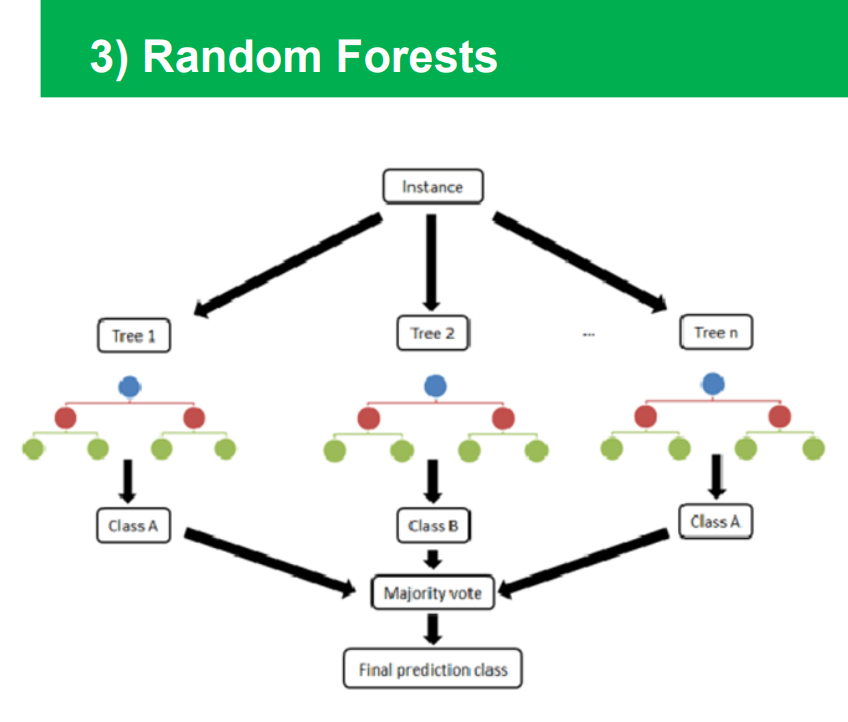

- **Importamos las librerias necesarias**

In [47]:
from sklearn.ensemble import RandomForestClassifier

- **Inicializamos y entrenamos el clasificador**

In [48]:
random_forest_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42,n_jobs=-1)
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=500, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

El código anterior entrena un clasificador de bosque aleatorio con 500 árboles (n_estimators=500) y utiliza todos los núcleos de CPU disponibles, como hemos especificado n_jobs =-1, cada uno de ellos limitado a un máximo de 16 nodos.

- **Prediccion y Evaluacion**

In [53]:
y_pred_random_forest = random_forest_clf.predict(X_test)
y_pred_random_forest

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

Creemos un clasificador de Bagging similar y comparemos sus predicciones con las del clasificador de bosque aleatorio.

- **Inicializamos y entrenamos el clasificador**

In [50]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=16),
    n_estimators=500, random_state=101)

- **Entrenamiento y Prediccion**

In [54]:
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
y_pred_bagging

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

Ahora, comparemos las predicciones del clasificador de Bagging (y_pred_bagging) y el bosque aleatorio (y_pred_random_forest) para ver qué obtenemos:

In [52]:
np.sum(y_pred_bagging == y_pred_random_forest) / len(y_pred_bagging)

0.9635416666666666

Como podemos ver, casi el 96,3% de las predicciones del clasificador Bagging y Random Forest son similares.